In [1]:
from nltk.corpus import stopwords
import string
import re
from os import listdir
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from pandas import DataFrame
import matplotlib.pyplot as plt 

C:\Users\mgangwar\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#loading file
def load_doc(filename):
    file = open(filename,'r')
    text = file.read()
    file.close()
    return text

In [3]:
#turning a doc into clean tokens
def clean_doc(doc):
    tokens = doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    #remove punctuation
    token = [re_punc.sub(' ',w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [w for w in tokens if len(w)>1]
    return tokens

In [4]:
#creating tokens on a single file
neg = load_doc('txt_sentoken/pos/cv000_29590.txt') 
token = clean_doc(neg)
print(token)

['films', 'adapted', 'comic', 'books', 'plenty', 'success', 'whether', 'superheroes', 'batman', 'superman', 'spawn', 'geared', 'toward', 'kids', 'casper', 'arthouse', 'crowd', 'ghost', 'world', 'never', 'really', 'comic', 'book', 'like', 'hell', 'starters', 'created', 'alan', 'moore', 'eddie', 'campbell', 'brought', 'medium', 'whole', 'new', 'level', 'mid', 'series', 'called', 'watchmen', 'say', 'moore', 'campbell', 'thoroughly', 'researched', 'subject', 'jack', 'ripper', 'would', 'like', 'saying', 'michael', 'jackson', 'starting', 'look', 'little', 'odd', 'book', 'graphic', 'novel', 'pages', 'long', 'includes', 'nearly', 'consist', 'nothing', 'footnotes', 'words', 'dismiss', 'film', 'source', 'get', 'past', 'whole', 'comic', 'book', 'thing', 'might', 'find', 'another', 'stumbling', 'block', 'directors', 'albert', 'allen', 'hughes', 'getting', 'hughes', 'brothers', 'direct', 'seems', 'almost', 'ludicrous', 'casting', 'carrot', 'top', 'well', 'anything', 'riddle', 'better', 'direct', 'f

##### Defining a Vocabulary

In [5]:
def add_doc_to_vocab(filename,vocab):
    doc = load_doc(filename)
    tokens = clean_doc(doc)
    vocab.update(tokens)

In [6]:
def process_docs(directory,vocab):
    for filename in listdir(directory):
        if filename.startswith('cv9'):
            continue
        path = directory +'/'+filename
        add_doc_to_vocab(path,vocab)

In [7]:
from collections import Counter
vocab = Counter()
process_docs('txt_sentoken/pos',vocab)
process_docs('txt_sentoken/neg',vocab)

print(len(vocab))
# top 50 most common words used in the reviews
print(vocab.most_common(50))

36053
[('film', 7974), ('one', 4939), ('movie', 4815), ('like', 3193), ('even', 2261), ('good', 2073), ('time', 2039), ('story', 1899), ('would', 1843), ('much', 1823), ('also', 1757), ('get', 1723), ('character', 1699), ('two', 1642), ('characters', 1618), ('first', 1586), ('see', 1553), ('way', 1515), ('well', 1477), ('make', 1418), ('really', 1400), ('little', 1347), ('films', 1338), ('life', 1329), ('plot', 1286), ('people', 1267), ('could', 1248), ('bad', 1246), ('scene', 1240), ('never', 1197), ('best', 1176), ('new', 1139), ('scenes', 1132), ('many', 1129), ('man', 1122), ('know', 1092), ('movies', 1027), ('great', 1011), ('another', 992), ('action', 980), ('love', 975), ('us', 967), ('go', 950), ('director', 947), ('something', 944), ('end', 943), ('still', 935), ('seems', 930), ('back', 921), ('made', 911)]


In [8]:
tokens = [k for k,c in vocab.items() if c>= 2]
print(len(tokens))

23275


In [9]:
#saving token or vocab in a txt file
data = '\n'.join(tokens)
file = open('vocab.txt','w')
file.write(data)
file.close()

In [10]:
#load the vocubulary 
vocab_file = 'vocab.txt'
vocab = load_doc(vocab_file)
vocab = set(vocab.split())
len(vocab)

23275

In [11]:
#load doc, clean and return line of tokens()
def doc_to_line(filename,vocab):
    doc = load_doc(filename)
    tokens = clean_doc(doc)
    tokens = [w for w in tokens if w in vocab]
    return ' '.join(tokens)

In [12]:
def process_docs(directory, vocab, is_train):
    lines = list()
    # walk through all files in the folder
    for filename in listdir(directory):
        # skip any reviews in the test set
        if is_train and filename.startswith('cv9'):
            continue
        if not is_train and not filename.startswith('cv9'):
            continue
        # create the full path of the file to open
        path = directory + '/' + filename
        # load and clean the doc
        line = doc_to_line(path, vocab)
        # add to list
        lines.append(line)
    return lines

In [13]:
def load_clean_dataset(vocab,is_train):
    neg = process_docs('txt_sentoken/neg',vocab,is_train)
    pos = process_docs('txt_sentoken/pos',vocab,is_train)
    docs = neg + pos

    labels = [0 for _ in range (len(neg))] + [1 for _ in range(len(pos))]
    return docs,labels

#### Movie reviews to bag of words vector

In [14]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [15]:
train_docs, ytrain = load_clean_dataset(vocab,True)
test_docs, ytest = load_clean_dataset(vocab,False)

tokenizer = create_tokenizer(train_docs)

Xtrain = tokenizer.texts_to_matrix(train_docs,mode='freq')
Xtest = tokenizer.texts_to_matrix(test_docs,mode='freq')

print(Xtrain.shape , Xtest.shape)

(1800, 23276) (200, 23276)


In [16]:
def define_model(n_words):
    model = Sequential()
    model.add(Dense(50,input_shape=(n_words,),activation='relu'))
    model.add(Dense(25,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy' ,optimizer='adam',metrics=['accuracy'])
    #model.summary()
    return model

In [17]:
n_words = Xtest.shape[1]
model = define_model(n_words)
model.fit(Xtrain,ytrain,epochs=10,verbose=2)

Epoch 1/10
 - 2s - loss: 0.6915 - acc: 0.5394
Epoch 2/10
 - 2s - loss: 0.6707 - acc: 0.6272
Epoch 3/10
 - 2s - loss: 0.5976 - acc: 0.8350
Epoch 4/10
 - 2s - loss: 0.4549 - acc: 0.9361
Epoch 5/10
 - 2s - loss: 0.2933 - acc: 0.9728
Epoch 6/10
 - 2s - loss: 0.1769 - acc: 0.9872
Epoch 7/10
 - 2s - loss: 0.1084 - acc: 0.9967
Epoch 8/10
 - 2s - loss: 0.0690 - acc: 0.9978
Epoch 9/10
 - 2s - loss: 0.0452 - acc: 1.0000
Epoch 10/10
 - 2s - loss: 0.0314 - acc: 1.0000


In [18]:
loss,acc = model.evaluate(Xtest,ytest,verbose=10)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 91.000000


#### Comparing Word Scoring Models

The texts to matrix() function for the Tokenizer in the Keras API provides 4 different
methods for scoring words; they are:

 binary Where words are marked as present (1) or absent (0).

 count Where the occurrence count for each word is marked as an integer.

 tfidf Where each word is scored based on their frequency, where words that are common
across all documents are penalized.

 freq Where words are scored based on their frequency of occurrence within the document.

In [19]:
def prepare_data(train_docs, test_docs, mode):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_docs)
    Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
    Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode)
    return Xtrain, Xtest

In [20]:
def evaluate_mode(Xtrain, ytrain, Xtest, ytest):
    scores = list()
    n_repeats = 10
    n_words = Xtest.shape[1]
    for i in range(n_repeats):
        # define network
        model = define_model(n_words)
        model.fit(Xtrain, ytrain, epochs=10, verbose=0)
        _, acc = model.evaluate(Xtest, ytest, verbose=0)
        scores.append(acc)
        print('%d accuracy: %s' % ((i+1), acc))
    return scores

In [21]:
from pandas import DataFrame
modes = ['binary','count','tfidf','freq']
results = DataFrame()
for mode in modes:
    print(mode)
    Xtrain,Xtest = prepare_data(train_docs,test_docs,mode)
    results[mode] = evaluate_mode(Xtrain,ytrain,Xtest,ytest)

binary
1 accuracy: 0.935
2 accuracy: 0.92
3 accuracy: 0.935
4 accuracy: 0.915
5 accuracy: 0.935
6 accuracy: 0.925
7 accuracy: 0.93
8 accuracy: 0.935
9 accuracy: 0.915
10 accuracy: 0.92
count
1 accuracy: 0.9
2 accuracy: 0.905
3 accuracy: 0.89
4 accuracy: 0.9
5 accuracy: 0.905
6 accuracy: 0.89
7 accuracy: 0.89
8 accuracy: 0.895
9 accuracy: 0.905
10 accuracy: 0.9
tfidf
1 accuracy: 0.885
2 accuracy: 0.885
3 accuracy: 0.885
4 accuracy: 0.82
5 accuracy: 0.87
6 accuracy: 0.865
7 accuracy: 0.865
8 accuracy: 0.875
9 accuracy: 0.865
10 accuracy: 0.84
freq
1 accuracy: 0.925
2 accuracy: 0.9
3 accuracy: 0.915
4 accuracy: 0.91
5 accuracy: 0.92
6 accuracy: 0.9
7 accuracy: 0.92
8 accuracy: 0.915
9 accuracy: 0.895
10 accuracy: 0.915


          binary      count      tfidf       freq
count  10.000000  10.000000  10.000000  10.000000
mean    0.926500   0.898000   0.865500   0.911500
std     0.008515   0.006325   0.021009   0.010014
min     0.915000   0.890000   0.820000   0.895000
25%     0.920000   0.891250   0.865000   0.902500
50%     0.927500   0.900000   0.867500   0.915000
75%     0.935000   0.903750   0.882500   0.918750
max     0.935000   0.905000   0.885000   0.925000


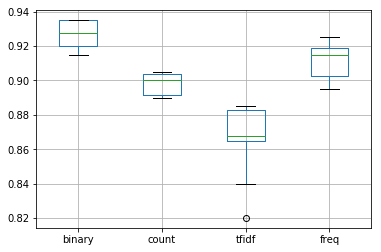

In [22]:
print(results.describe())
results.boxplot()
plt.show()

In [23]:
def predict_sentiment(review,vocab,tokenizer,model):
    tokens = clean_doc(review)
    tokens = [w for w in tokens if w in vocab]
    line = ' '.join(tokens)
    encoded = tokenizer.texts_to_matrix([line],mode='binary')
    yhat = model.predict(encoded, verbose=0)
    percent_pos = yhat[0,0]
    if round(percent_pos) == 0:
        return (1-percent_pos), 'NEGATIVE'
    return percent_pos, 'POSITIVE'

In [24]:
#choosing binary as it performing better than the other two
Xtrain = tokenizer.texts_to_matrix(train_docs, mode='binary')
Xtest = tokenizer.texts_to_matrix(test_docs, mode='binary')
# define network
n_words = Xtrain.shape[1]
model = define_model(n_words)
# fit network
model.fit(Xtrain, ytrain, epochs=10, verbose=2)

Epoch 1/10
 - 3s - loss: 0.4560 - acc: 0.7878
Epoch 2/10
 - 2s - loss: 0.0406 - acc: 0.9933
Epoch 3/10
 - 2s - loss: 0.0065 - acc: 1.0000
Epoch 4/10
 - 2s - loss: 0.0024 - acc: 1.0000
Epoch 5/10
 - 2s - loss: 0.0011 - acc: 1.0000
Epoch 6/10
 - 2s - loss: 5.8979e-04 - acc: 1.0000
Epoch 7/10
 - 2s - loss: 3.6994e-04 - acc: 1.0000
Epoch 8/10
 - 2s - loss: 2.5699e-04 - acc: 1.0000
Epoch 9/10
 - 2s - loss: 1.8647e-04 - acc: 1.0000
Epoch 10/10
 - 2s - loss: 1.4259e-04 - acc: 1.0000


In [25]:
text = 'Best movie ever! It was great, I recommend it.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))

Review: [Best movie ever! It was great, I recommend it.]
Sentiment: NEGATIVE (52.887%)


In [26]:
text = 'This is a bad movie.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))

Review: [This is a bad movie.]
Sentiment: NEGATIVE (68.379%)


In [27]:
text = 'This movie wasn\'t worth watching.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))

Review: [This movie wasn't worth watching.]
Sentiment: NEGATIVE (54.934%)
